In [1]:
import os
import zipfile
import shutil
import PIL
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [5]:
# dogs-vs-cats dataset
# 다운로드 링크: www.kaggle.com/c/dogs-vs-cats/data

data_zip_dir = 'data/dogs-vs-cats'
train_zip_dir = os.path.join(data_zip_dir, 'train.zip')
test_zip_dir = os.path.join(data_zip_dir, 'test.zip')
 
#with zipfile.ZipFile(train_zip_dir, 'r') as z:
#    z.extractall()
#with zipfile.ZipFile(test_zip_dir, 'r') as z:
#    z.extractall()

In [7]:
train_dir = os.path.join(data_zip_dir, 'train')
test_dir = os.path.join(data_zip_dir, 'test')

train_set_dir = os.path.join(train_dir, 'train')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
os.mkdir(test_set_dir)

dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

In [8]:
for dog, cat in zip(dog_files[:10000], cat_files[:10000]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(train_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(train_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(valid_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(valid_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[11250:12500], cat_files[11250:12500]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(test_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(test_set_dir, cat)
    shutil.move(src, dst)

In [9]:
print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validation set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validation set : 2500
the number of test set : 2500


In [10]:
# torch.utils.data.Dataset을 사용하여 custom dataset 만들기
# 참고: https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

class CustomDataset(Dataset):    
    '''
    __init__(self, files, root, mode='train', transform=None) :
        ㄴfiles : 이미지 파일 이름을 저장하고 있는 list
        ㄴroot : 이미지 파일이 존재하는 폴더 경로
        ㄴmode : 해당 dataset이 train용인지 eval용인지 체크
        ㄴtransform : 이미지의 전처리를 위한 torchvision.transform
    '''
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform = transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
            
    '''
    __len__(self) : Dataset의 길이를 반환하기 위한 메소드
    '''    
    def __len__(self):
        return len(self.files)
    
    '''
    __getitem__(self, index) : 주어진 key에 해당하는 data를 반환하는 메소드이며,
                               key에 해당하는 이미지 파일을 읽고, 전처리 과정을 통해서 data를 리턴합니다. 
                               mode='train'일 경우에는 label을 반환하고, 'train'용이 아닌 경우에는 label을 모르기 때문에 
                               실제 이미지 파일의 경로를 반환하도록 합니다.
    '''    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [11]:
train_transform = transforms.Compose([transforms.Resize((150, 150)),
                                      #transforms.RandomCrop(224),
                                      #transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
                                     ])

test_transform = transforms.Compose([transforms.Resize((150, 150)),
                                     transforms.ToTensor()
                                    ])

In [13]:
train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:12500], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:12500], test_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [35]:
train_dataset[0]

(tensor([[[0.4588, 0.4314, 0.4471,  ..., 0.5373, 0.5216, 0.5216],
          [0.4706, 0.4392, 0.4549,  ..., 0.5451, 0.5294, 0.5294],
          [0.4824, 0.4510, 0.4627,  ..., 0.5569, 0.5373, 0.5333],
          ...,
          [0.2902, 0.2902, 0.2706,  ..., 0.2549, 0.2392, 0.2510],
          [0.2784, 0.2784, 0.2667,  ..., 0.2471, 0.2667, 0.2902],
          [0.2667, 0.2667, 0.2549,  ..., 0.3059, 0.2980, 0.2667]],
 
         [[0.4510, 0.4235, 0.4392,  ..., 0.5451, 0.5294, 0.5216],
          [0.4627, 0.4314, 0.4431,  ..., 0.5529, 0.5373, 0.5333],
          [0.4745, 0.4431, 0.4549,  ..., 0.5647, 0.5451, 0.5451],
          ...,
          [0.3216, 0.3176, 0.3020,  ..., 0.2902, 0.2745, 0.2902],
          [0.3020, 0.3098, 0.3059,  ..., 0.2824, 0.3020, 0.3255],
          [0.2863, 0.2980, 0.2941,  ..., 0.3412, 0.3333, 0.3020]],
 
         [[0.4980, 0.4784, 0.4941,  ..., 0.5922, 0.5765, 0.5569],
          [0.5059, 0.4863, 0.5020,  ..., 0.6000, 0.5843, 0.5686],
          [0.5176, 0.4980, 0.5098,  ...,

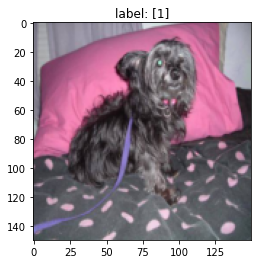

In [22]:
image = train_dataset[0][0].permute(1, 2, 0)
label = train_dataset[0][1]
plt.imshow(image)
plt.title(f'label: {label}')
plt.show()

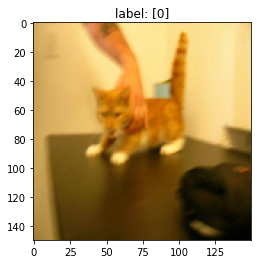

In [23]:
image = train_dataset[10000][0].permute(1, 2, 0)
label = train_dataset[10000][1]
plt.imshow(image)
plt.title(f'label: {label}')
plt.show()

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # input shape: 150x150x3
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2),
                                   nn.Conv2d(32, 64, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)
                                   )
        
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2),
                                   nn.Conv2d(128, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)
                                   )
        
        self.fc = nn.Sequential(nn.Flatten(),
                               nn.Linear(128*9*9, 512),
                               nn.ReLU(),
                               nn.Linear(512, 1),
                               nn.Sigmoid()
                               )        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc(out)
        return out

In [17]:
from torchsummary import summary

model = CNN().to(device)
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
              ReLU-2         [-1, 32, 150, 150]               0
         MaxPool2d-3           [-1, 32, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          18,496
              ReLU-5           [-1, 64, 75, 75]               0
         MaxPool2d-6           [-1, 64, 37, 37]               0
            Conv2d-7          [-1, 128, 37, 37]          73,856
              ReLU-8          [-1, 128, 37, 37]               0
         MaxPool2d-9          [-1, 128, 18, 18]               0
           Conv2d-10          [-1, 128, 18, 18]         147,584
             ReLU-11          [-1, 128, 18, 18]               0
        MaxPool2d-12            [-1, 128, 9, 9]               0
          Flatten-13                [-1, 10368]               0
           Linear-14                  [

In [18]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader): 
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []    
    
    train_loss = 0
    train_acc = 0
    train_correct = 0    
    for epoch in range(epochs):
        start = time.time()        
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()            
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
            
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()                
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()                
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
                
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
            
        train_acc = train_correct / len(train_loader.dataset)
        valid_acc = valid_correct / len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

In [19]:
epochs = 30
learning_rate = 1e-4
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

149.229sec : [Epoch 1/30] -> train loss: 0.6348, train acc: 63.450% / valid loss: 0.5792, valid acc: 67.600%
76.658sec : [Epoch 2/30] -> train loss: 0.5451, train acc: 72.390% / valid loss: 0.5026, valid acc: 75.320%
76.435sec : [Epoch 3/30] -> train loss: 0.5065, train acc: 74.995% / valid loss: 0.5463, valid acc: 71.840%
77.169sec : [Epoch 4/30] -> train loss: 0.4735, train acc: 77.365% / valid loss: 0.4683, valid acc: 77.560%
82.092sec : [Epoch 5/30] -> train loss: 0.4491, train acc: 78.910% / valid loss: 0.4318, valid acc: 79.040%
83.278sec : [Epoch 6/30] -> train loss: 0.4235, train acc: 80.710% / valid loss: 0.4516, valid acc: 78.320%
80.957sec : [Epoch 7/30] -> train loss: 0.3992, train acc: 82.010% / valid loss: 0.4260, valid acc: 78.680%
80.810sec : [Epoch 8/30] -> train loss: 0.3828, train acc: 82.725% / valid loss: 0.4070, valid acc: 81.520%
82.443sec : [Epoch 9/30] -> train loss: 0.3666, train acc: 83.640% / valid loss: 0.3939, valid acc: 82.000%
81.895sec : [Epoch 10/30] -

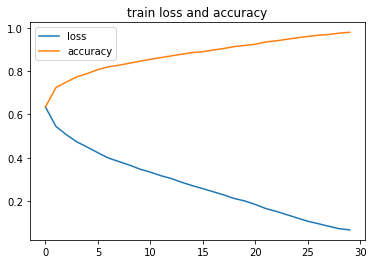

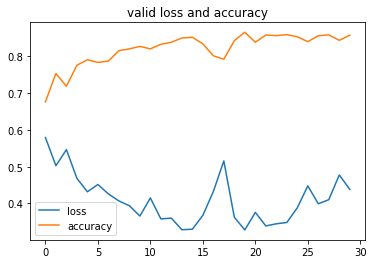

In [20]:
fit(model, criterion, optimizer, epochs, train_loader, valid_loader)

82.967sec : [Epoch 1/30] -> train loss: 0.6518, train acc: 60.595% / valid loss: 0.6004, valid acc: 67.480%
81.385sec : [Epoch 2/30] -> train loss: 0.5654, train acc: 70.640% / valid loss: 0.5240, valid acc: 73.520%
80.542sec : [Epoch 3/30] -> train loss: 0.5164, train acc: 74.645% / valid loss: 0.5006, valid acc: 75.600%
82.318sec : [Epoch 4/30] -> train loss: 0.4812, train acc: 77.140% / valid loss: 0.4717, valid acc: 76.960%
80.879sec : [Epoch 5/30] -> train loss: 0.4446, train acc: 79.160% / valid loss: 0.4371, valid acc: 78.360%
80.158sec : [Epoch 6/30] -> train loss: 0.4136, train acc: 81.200% / valid loss: 0.4133, valid acc: 81.040%
79.931sec : [Epoch 7/30] -> train loss: 0.3928, train acc: 82.085% / valid loss: 0.3958, valid acc: 81.400%
80.163sec : [Epoch 8/30] -> train loss: 0.3761, train acc: 83.040% / valid loss: 0.3923, valid acc: 82.520%
78.941sec : [Epoch 9/30] -> train loss: 0.3599, train acc: 83.820% / valid loss: 0.3646, valid acc: 82.720%
78.050sec : [Epoch 10/30] ->

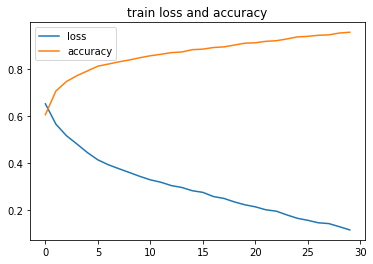

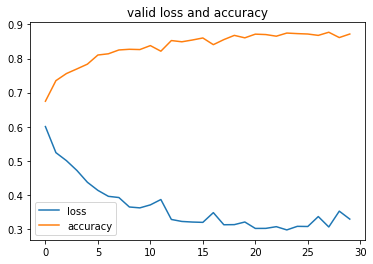

In [21]:
model_adam = CNN().to(device)
optimizer = torch.optim.Adam(model_adam.parameters(), lr=learning_rate)

fit(model_adam, criterion, optimizer, epochs, train_loader, valid_loader)